## Lab 2.1 - Using PyTorch for Binary Classification


### Load data and pre-process
> Source data: http://archive.ics.uci.edu/ml/datasets/Glass+Identification 

In [88]:
import numpy as np  
import torch
import torch.nn.functional as F
import pandas as pd 

In [89]:
# there's no header beware
data = pd.read_csv('glass.data', header=None)

# drop first column of indices
data.drop(data.columns[0], axis=1, inplace=True)

# the original data is ordered, so shuffle it
data = data.sample(frac=1).reset_index(drop=True)

# treat type 1 to 5 as type 0, type 5 to 7 as type 1
data.at[data[data.shape[1]] < 5, data.shape[1]] = 0
data.at[data[data.shape[1]] > 4, data.shape[1]] = 1
# alternatively
# data[data.shape[1]] = (data[data.shape[1]] < 5).astype(int)

# manually split data into 80% for training and 20% for test (use a full length mask to screen)
msk = np.random.rand(len(data)) < 0.8
data_train = data[msk]
data_test = data[~msk]

# get feature numbers
num_feat = data.shape[1] - 1

# split data into inputs and target: 1. convert dataframe to arrays using .values; 2. .iloc
train_inputs = data_train.iloc[:, :num_feat]
train_target = data_train.iloc[:, num_feat]
test_inputs = data_test.iloc[:, :num_feat]
test_target = data_test.iloc[:, num_feat]

# create tensors, dataframe is diff from array, so need to convert first
X_train = torch.tensor(train_inputs.values, dtype=torch.float)
Y_train = torch.tensor(train_target.values, dtype=torch.long)
# alternatively, use torch.Tensor(input.values).float()



In [90]:
print(data.shape[1])

10


### Define a network

In [91]:
# the followings can be used as a template
# TODO define the number of inputs, hidden neurons, classes(2 for simplification for this task), training epochs, learning rate
num_inputs = num_feat
num_classes = 2
num_hidden_neurons = 10
epochs = 500
learning_rate = 0.01

# TODO define a customised nn structure
class TwoLayerNet(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(TwoLayerNet, self).__init__()
        self.hidden = torch.nn.Linear(n_input, n_hidden)
        self.output = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        h_input = self.hidden(x)

        # sigmoid as activation func
        h_output = F.sigmoid(h_input)

        y_pred = self.output(h_output)
        return y_pred

# TODO define a nn using the customized structure
net = TwoLayerNet(num_inputs, num_hidden_neurons, num_classes)

# TODO define loss function using cross-entropy
loss_func = torch.nn.CrossEntropyLoss()

# TODO define optimiser with SGD
# what's the difference between SGD and Adam or other optimizer?
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

### Train and test nn

Epoch: [0/500] loss: 1.1188 accuracy: 25.44 %
Epoch: [50/500] loss: 0.5684 accuracy: 74.56 %
Epoch: [100/500] loss: 0.5672 accuracy: 74.56 %
Epoch: [150/500] loss: 0.5672 accuracy: 74.56 %
Epoch: [200/500] loss: 0.5672 accuracy: 74.56 %
Epoch: [250/500] loss: 0.5672 accuracy: 74.56 %
Epoch: [300/500] loss: 0.5672 accuracy: 74.56 %
Epoch: [350/500] loss: 0.3923 accuracy: 76.33 %
Epoch: [400/500] loss: 0.2030 accuracy: 94.67 %
Epoch: [450/500] loss: 0.1643 accuracy: 95.27 %


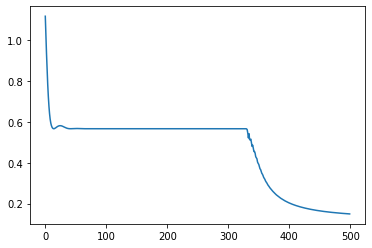

In [92]:
all_losses = []

# train 
for epoch in range(epochs):
    Y_train_pred = net(X_train)
    loss = loss_func(Y_train_pred, Y_train)
    all_losses.append(loss.item())
    if epoch % 50 == 0:
        _, predicted = torch.max(Y_train_pred, 1)
        total = Y_train.data.size(0)
        correct = sum(predicted.data.numpy() == Y_train.data.numpy())
        print('Epoch: [%d/%d] loss: %.4f accuracy: %.2f %%' % (epoch, epochs, loss, 100*correct/total))
    
    # clear gradients before running backward pass
    net.zero_grad()

    # backward pass
    loss.backward()

    # optimizer SGD step function to update parameters
    optimizer.step()

# plot the loss trend
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_losses)
plt.show()


In [93]:
# confusion matrix to show accuracy
confusion = torch.zeros(num_classes, num_classes)
for i in range(Y_train.data.size(0)):
    actual = Y_train.data[i]
    pred = predicted.data[i]
    confusion[actual][pred] += 1
print('Confusion matrix: \n', confusion.data.numpy())

Confusion matrix: 
 [[123.   3.]
 [  5.  38.]]


### Test nn

In [94]:
# convert dataframe to tensor
X_test = torch.tensor(test_inputs.values, dtype=torch.float)
Y_test = torch.tensor(test_target.values, dtype=torch.long)

Y_test_pred = net(X_test)
_, predicted = torch.max(Y_test_pred, 1)

total_test = Y_test.data.size(0)
correct_test = sum(predicted.data.numpy() == Y_test.data.numpy())

print('Test accuracy: %.2f %%' % (100*correct_test/total_test))

Test accuracy: 86.67 %


In [95]:
# confusion matrix
confusion_test = torch.zeros(num_classes, num_classes)
for i in range(total_test):
    actual = Y_test.data[i]
    pred = predicted.data[i]
    confusion_test[actual][pred] += 1
print('Confusion matrix for test: \n', confusion_test.data.numpy())

Confusion matrix for test: 
 [[33.  4.]
 [ 2.  6.]]
